# Introduction

In the nsrdb_srrl_exploratory_analysis notebook, we saw that NSRDB is more generous at classifying clear sky times.  This was an expected outcome as clear skies are designated 30min at a time.  What we also saw, was cases where SRRL measurements were labeled as cloudy, but looked clear due (from a glance).  In this notebook, we will try to see which tests are failed and why.  The 'components' of the detect_clearksy method will be extracted :

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

# Load SRRL and NSRDB data

SRRL data is available at https://www.nrel.gov/midc/srrl_bms/ and NSRDB data is available at http://bit.ly/2oFzFMI.  NSRDB is not as up to date as SRRL, so we will just use 2014 (and sub-samples thereof) for analysis.

In [2]:
srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
nsrdb_file = os.path.expanduser('~/data_sets/nsrdb/SRRL_BMS_2010_global.csv')

In [3]:
srrl_data = pd.read_csv(srrl_file)

In [4]:
srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])

In [5]:
srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')

In [6]:
srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]

In [7]:
srrl_data = srrl_data.reindex(
    pd.date_range(start=srrl_data.index[0], end=srrl_data.index[-1], freq='1min')
).fillna(0)

In [8]:
srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)

In [9]:
nsrdb_cols = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'DHI', 'DNI', 'GHI', 'Cloud Type']

In [10]:
nsrdb_data = pd.read_csv(nsrdb_file, header=2, usecols=nsrdb_cols)

In [11]:
nsrdb_data[['Year', 'Month', 'Day', 'Hour', 'Minute']] = \
    nsrdb_data[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str)

In [12]:
nsrdb_data.index = pd.to_datetime(nsrdb_data['Year'] + '/' + 
                                  nsrdb_data['Month'] + '/' +
                                  nsrdb_data['Day'] + ' ' +
                                  nsrdb_data['Hour'] + ':' + 
                                  nsrdb_data['Minute'])

In [13]:
nsrdb_data.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True, axis=1)

In [14]:
nsrdb_data.index = nsrdb_data.index.tz_localize('Etc/GMT+7')

In [15]:
nsrdb_data = nsrdb_data.reindex(
    pd.date_range(start=nsrdb_data.index[0], end=nsrdb_data.index[-1], freq='1min')
).fillna(method='ffill')

In [16]:
data = nsrdb_data.join(srrl_data)

In [17]:
data.head()

,DHI,DNI,GHI,Cloud Type,Global 40-South PSP [W/m^2],Global 40-South LI-200 [W/m^2]
2014-01-01 00:00:00-07:00,0.0,0.0,0.0,6.0,NaN,NaN
2014-01-01 00:01:00-07:00,0.0,0.0,0.0,6.0,NaN,NaN
2014-01-01 00:02:00-07:00,0.0,0.0,0.0,6.0,NaN,NaN
2014-01-01 00:03:00-07:00,0.0,0.0,0.0,6.0,NaN,NaN
2014-01-01 00:04:00-07:00,0.0,0.0,0.0,6.0,NaN,NaN


# Set up PV_Lib clear sky detection

In [18]:
lat = 39.742
lon = -105.18
tilt = 40
azimuth = 180
elevation = 1828.8

system_noloc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
loc = pvlib.location.Location(lat, lon, altitude=elevation)
system_loc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=system_noloc, location=loc)

# Analysis function

We want to quanitify how well PVLib and NSRDB agree on cloudy/clear periods.  This agreement is defined as

## $A = \frac{1}{N_{\mathrm{CS}}} \sum_{i}^{N_{\text{CS}}} b_i c_i$

where $b_i$ represents PVLib clear sky (1 if clear, 0 if not) and $c_i$ represents NSRDB clear minutes (1 if clear, 0 if not).  $N_\text{CS}$ are the number of clear sky days (from either PVLIB or NSRDB classification).

In [19]:
def agreement_analysis(sample, clear_skies, window=10, 
                       start_end=None, return_components=True, viz=True, 
                       sample_key='Global 40-South LI-200 [W/m^2]', detection_kwargs={}):
    # detect clear skies
    if return_components:
        is_clear, components, alpha = pvlib.clearsky.detect_clearsky(sample[sample_key], 
                                                                     clear_skies['ghi'], sample.index, window, 
                                                                     return_components=True, **detection_kwargs)
        components = pd.DataFrame(components)
        while len(components) < len(sample):
            components.loc[len(components)] = [False] * 7
        components.index = sample.index
        # components.index = components.reindex(
        #     pd.date_range(start=sample.index[0], end=sample.index[-1], freq=sample.index.freq)
        # ).fillna(False)
    else:
        is_clear = pvlib.clearsky.detect_clearsky(sample[sample_key], 
                                                  clear_skies['ghi'], sample.index, window)
        alpha = 1
    
    if start_end is not None:
        sample = sample.between_time(start_end[0], start_end[1])
        clear_skies = sample.between_time(start_end[0], start_end[1])
        is_clear = is_clear.between_time(start_end[0], start_end[1])

    # make mask dataframe
    mask = pd.DataFrame()
    mask['pvlib'] = is_clear
    mask['nsrdb'] = (sample['Cloud Type'] == 0)
    mask['consensus'] = mask['pvlib'] & mask['nsrdb']
    
    # calculate maximum and actual agreement between pvlib, nsrdb
    agree_val = mask['consensus'].sum() / len(mask[(mask['pvlib']) | (mask['nsrdb'])]) * 100
    min_val = min(mask['pvlib'].sum(), mask['nsrdb'].sum())
    max_agree_val = min_val / len(mask[(mask['pvlib']) | (mask['nsrdb'])]) * 100                               
    
    # plot findings
    if viz:
        fig, ax = plt.subplots()
        
        _ = ax.plot(clear_skies['ghi'].index, alpha * clear_skies['ghi'], label='scaled model', c='black')

        _ = ax.plot(sample[sample_key].index, 
                sample[sample_key], label='GHI')

        # _ = ax.scatter(sample[sample_key][(mask['pvlib']) & (~mask['nsrdb'])].index,
        #            sample[sample_key][(mask['pvlib']) & (~mask['nsrdb'])], 
        #            marker='o', c='green', label='PVLib')

        _ = ax.scatter(sample[sample_key][(mask['pvlib'])].index,
                   sample[sample_key][(mask['pvlib'])], 
                   facecolors='none', edgecolors='green', label='clear sky')

        _ = ax.scatter(sample[sample_key][(mask['nsrdb']) & (~mask['pvlib'])].index,
                   sample[sample_key][(mask['nsrdb']) & (~mask['pvlib'])],
                   facecolors='none', edgecolors='orange', label='NSRDB')

        _ = ax.scatter(sample[sample_key][mask['consensus']].index,
                   sample[sample_key][mask['consensus']], 
                   facecolors='none', edgecolors='red', label='consensus')

        _ = ax.set_ylabel('GHI W/m2')
        _ = ax.set_xlabel('Date')
        _ = ax.legend()

    if return_components:
        return {'mask': mask,
                'components': components,
                'alpha': alpha,
                'max_agreement': max_agree_val,
                'agreement': agree_val}
    else:
        return {'mask': mask,
                'max_agreement': max_agree_val,
                'agreement': agree_val}

# Investigate potential detection errors

### Sample: First week of January

In [20]:
start_date = '2014-01-01'
end_date = '2014-01-08'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()

In [21]:
clear_skies = system_loc.get_clearsky(sample.index)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:680: RuntimeWarning: invalid value encountered in less
  c1 = np.abs(meas_mean - alpha*clear_mean) < mean_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:681: RuntimeWarning: invalid value encountered in less
  c2 = np.abs(meas_max - alpha*clear_max) < max_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in greater
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in less
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/l

<IPython.core.display.Javascript object>


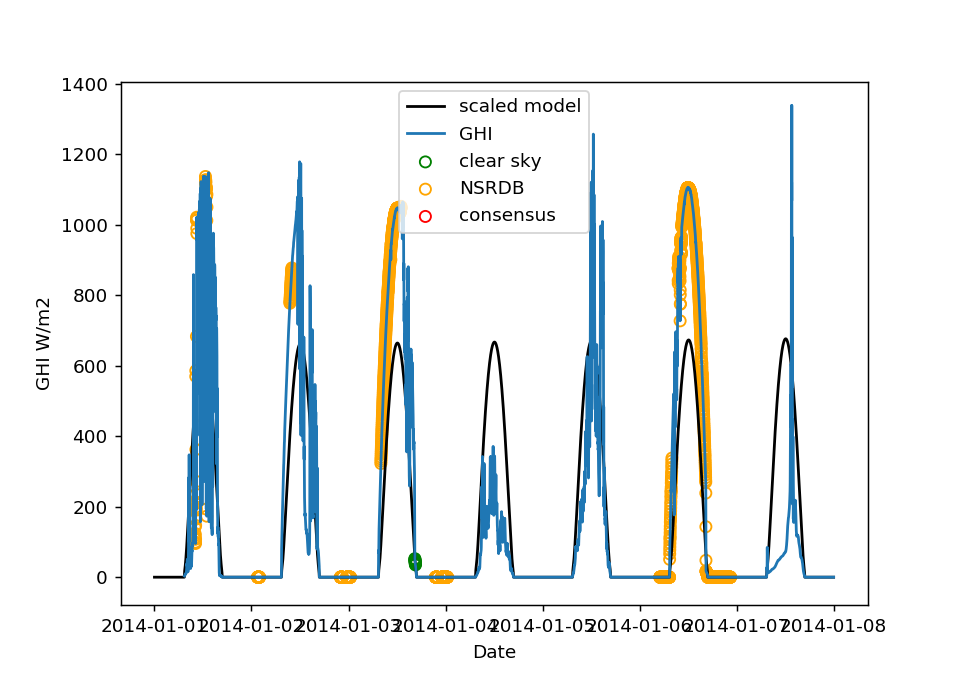

In [22]:
result = agreement_analysis(sample, clear_skies, return_components=True)

In [23]:
result['alpha']

1.2841691635283827

Almost no points are marked as clear sky by PVLib.  It appears that the model is not scaling correctly as the scaled model is much lower than the peaks of almost every measurements.  The algorithm in PVLib scales to 'already detected' clear skies.  As such, if it fits a very small number of points initially, it may get stuck in scaling the 

### Sample: First week of July

This is the same analysis as above,  except we restrict the time of day for detection (between 4:30AM and 10:00PM).  This is a very generous time frame, but we don't want to eleminate data that might be of interest.

In [24]:
start_date = '2014-07-01'
end_date = '2014-07-08'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()

In [25]:
clear_skies = system_loc.get_clearsky(sample.index)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


<IPython.core.display.Javascript object>


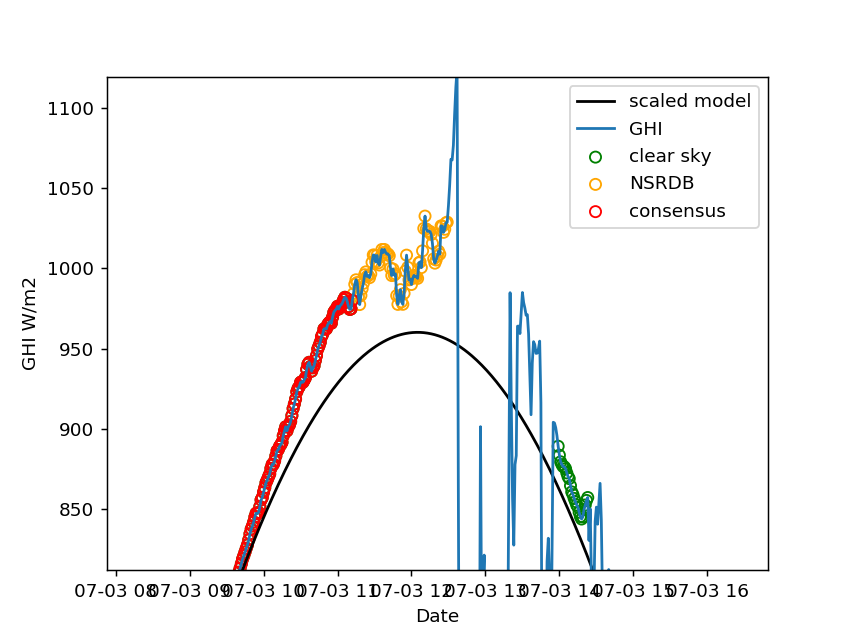

In [26]:
result = agreement_analysis(sample, clear_skies, return_components=True)

Periods that are 'suspiciously' undetected (times are approximate): 
* 7/1: afternoon (1330-1400, 1630-1700)
* 7/2: morning (0900-1000), afternoon (1500-1600)
* 7/3: morning (0700-0830)
* 7/4: morning (0600-0730)
* 7/5: n/a
* 7/6: morning (0700-0800)
* 7/7: morning (0630-0830)

The mornings of 7/3, 7/4, and 7/6 will be investigated first.  They seem to be the most obvious cases of error with the PVLib detection.

In [29]:
def concat_components(pvlib_classified, components, start_date, end_date):
    pvlib_classified = pvlib_classified[(pvlib_classified.index >= start_date) & 
                                        (pvlib_classified.index < end_date)]
    components = components[(components.index >= start_date) & 
                            (components.index < end_date)]
    final = components.join(pvlib_classified)
    return final
    

### July 3rd

In [30]:
start_date = '2014-07-03 07:30:00'
end_date = '2014-07-03 08:16:00'

In [31]:
components = result['components']

In [32]:
mask = result['mask']

In [33]:
detailed_info = concat_components(mask, components, start_date, end_date)

In [34]:
detailed_info

,mean_diff,max_diff,line_length,slope_nstd,slope_max,mean_nan,windows,pvlib,nsrdb,consensus
2014-07-03 07:30:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-03 07:31:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-03 07:32:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-03 07:33:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-03 07:34:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-03 07:35:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-03 07:36:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-03 07:37:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-03 07:38:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-03 07:39:00-07:00,False,False,True,True,True,True,False,False,True,False


It appears that with this detector/set up/parameters, the PVLib struggles to match early mornings correctly.  It fails based on mean_diff and max_diff, sometimes line length.  This is true until 8:06, where we see that 

This issue highlights the largest issue with PVLib: how does one hand tuning parameters without knowing if classification is being done correctly?

We will check the other dates of interest to verify the hypothesis that mean_diff and max_diff are the main culprits for why early mornings are not labeled as clear despite looking so.

### July 4th

In [35]:
start_date = '2014-07-04 06:00:00'
end_date = '2014-07-04 06:46:00'

In [36]:
components = result['components']

In [37]:
mask = result['mask']

In [38]:
detailed_info = concat_components(mask, components, start_date, end_date)

In [39]:
detailed_info

,mean_diff,max_diff,line_length,slope_nstd,slope_max,mean_nan,windows,pvlib,nsrdb,consensus
2014-07-04 06:00:00-07:00,False,False,False,False,True,True,False,False,True,False
2014-07-04 06:01:00-07:00,False,False,False,False,True,True,False,False,True,False
2014-07-04 06:02:00-07:00,False,False,False,False,True,True,False,False,True,False
2014-07-04 06:03:00-07:00,False,False,False,False,True,True,False,False,True,False
2014-07-04 06:04:00-07:00,False,False,False,False,True,True,False,False,True,False
2014-07-04 06:05:00-07:00,False,False,False,False,True,True,False,False,True,False
2014-07-04 06:06:00-07:00,False,False,False,False,True,True,False,False,True,False
2014-07-04 06:07:00-07:00,False,False,False,False,True,True,False,False,True,False
2014-07-04 06:08:00-07:00,False,False,False,False,True,True,False,False,True,False
2014-07-04 06:09:00-07:00,False,False,True,True,True,True,False,False,True,False


Once again, it appears that mean_diff and max_diff are the main reasons why these periods are not listed as clear.  Line length is also an issue early on, but we see that before 6:09/6:10, the measured curve has a very soft slope.  It increases to be much more consistent with the model curve soon after this time, which makes it less of a concern, though it still appears that it should have been labeled clear.

### July 6th

In [40]:
start_date = '2014-07-06 07:30:00'
end_date = '2014-07-06 08:16:00'

In [41]:
components = result['components']

In [42]:
mask = result['mask']

In [43]:
detailed_info = concat_components(mask, components, start_date, end_date)

In [44]:
detailed_info

,mean_diff,max_diff,line_length,slope_nstd,slope_max,mean_nan,windows,pvlib,nsrdb,consensus
2014-07-06 07:30:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-06 07:31:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-06 07:32:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-06 07:33:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-06 07:34:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-06 07:35:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-06 07:36:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-06 07:37:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-06 07:38:00-07:00,False,False,True,True,True,True,False,False,True,False
2014-07-06 07:39:00-07:00,False,False,True,True,True,True,False,False,True,False


This third sample once again shows that mean_diff and max_diff are the reasons why seemingly clear sky is labeled as cloudy.  Changing the tolerane to be more lenient will likely fix this issue, but it will also affect the entire detection system since scaling to the model is applied globally.

# Tolerance tuning

Default tolerances for detect_clearsky are as follows:
* mean_diff=75
* max_diff=75
* lower_line_length=-5
* upper_line_length=10,
* var_diff=0.005 
* slope_dev=8

Changing the mean_diff and max_diff to be larger than 75W is very accommodating.  At some points of apparent clear sky GHI measurements, power is as low as ~225W.  It might be possible worthwhile to look into a relative scale as opposed ot an absolute one.  For example, all measured windows can differ from all clear sky windows by +/- 10% of model.

In [49]:
start_date = '2014-07-01'
end_date = '2014-07-08'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()

In [50]:
clear_skies = system_loc.get_clearsky(sample.index)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


<IPython.core.display.Javascript object>


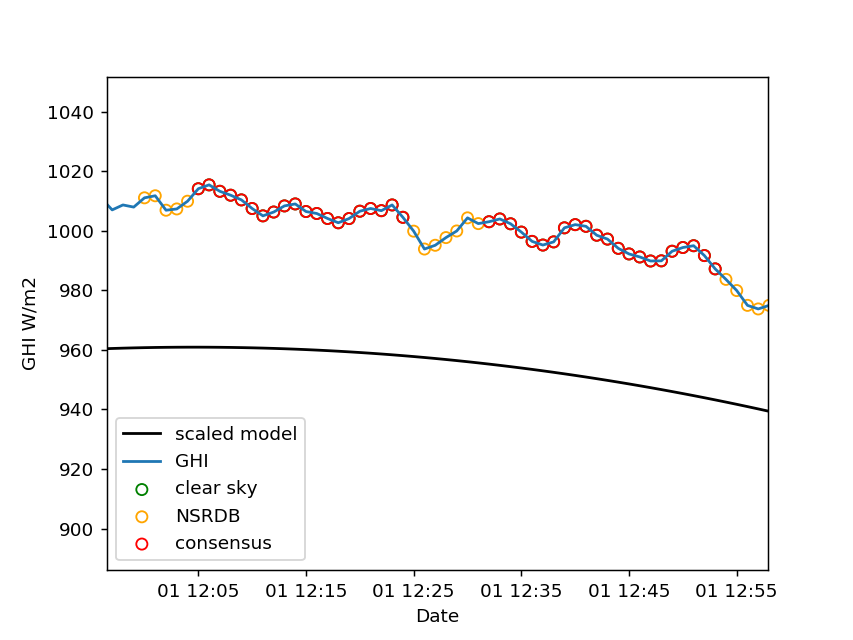

<IPython.core.display.Javascript object>


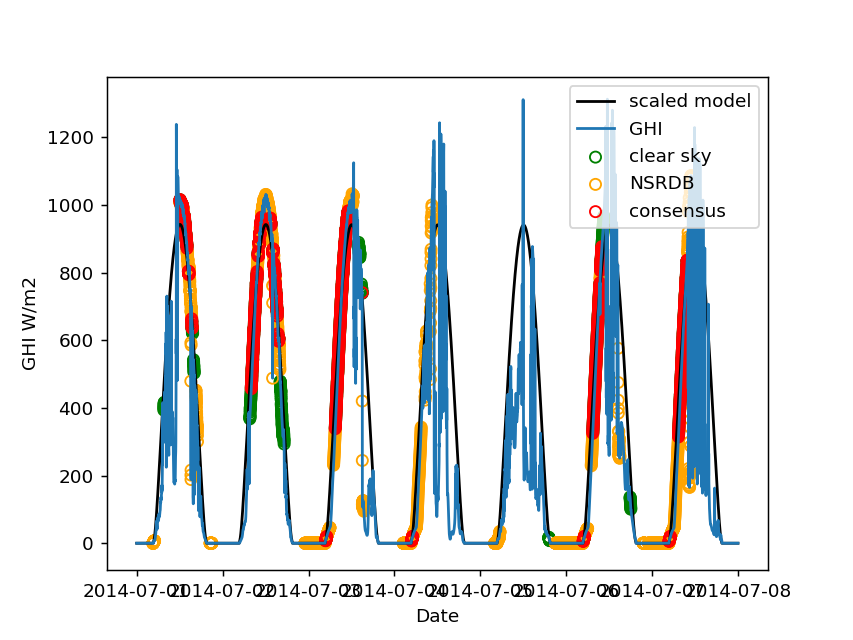

<IPython.core.display.Javascript object>


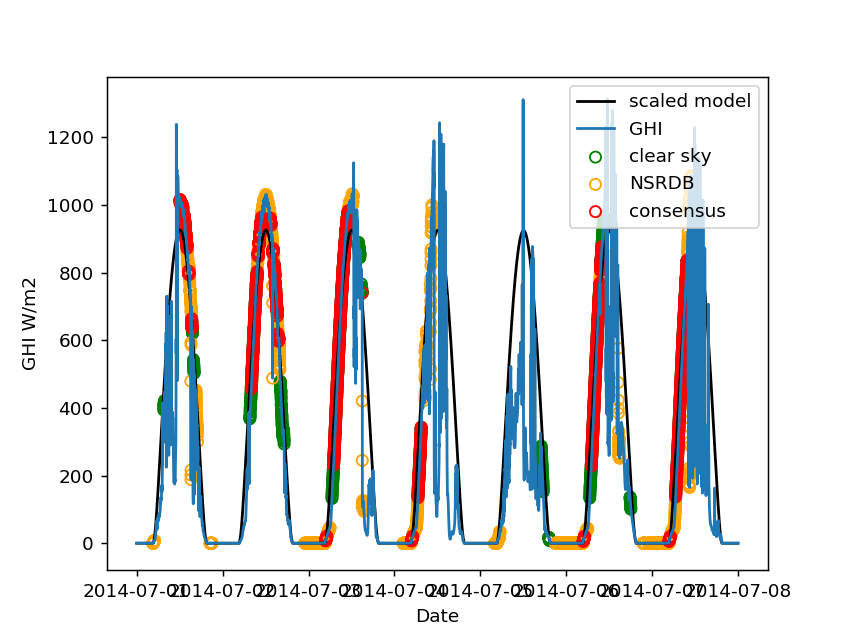

In [52]:
result_default = agreement_analysis(sample, clear_skies, 
                            return_components=True)
result_altered = agreement_analysis(sample, clear_skies, 
                            return_components=True, detection_kwargs={'mean_diff': 100, 'max_diff': 100})
result_altered2 = agreement_analysis(sample, clear_skies, 
                            return_components=True, detection_kwargs={'mean_diff': 125, 'max_diff': 125})

# Test

In [53]:
start_date = '2014-01-01'
end_date = '2014-01-02'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()

In [54]:
clear_skies = system_loc.get_clearsky(sample.index)

<IPython.core.display.Javascript object>


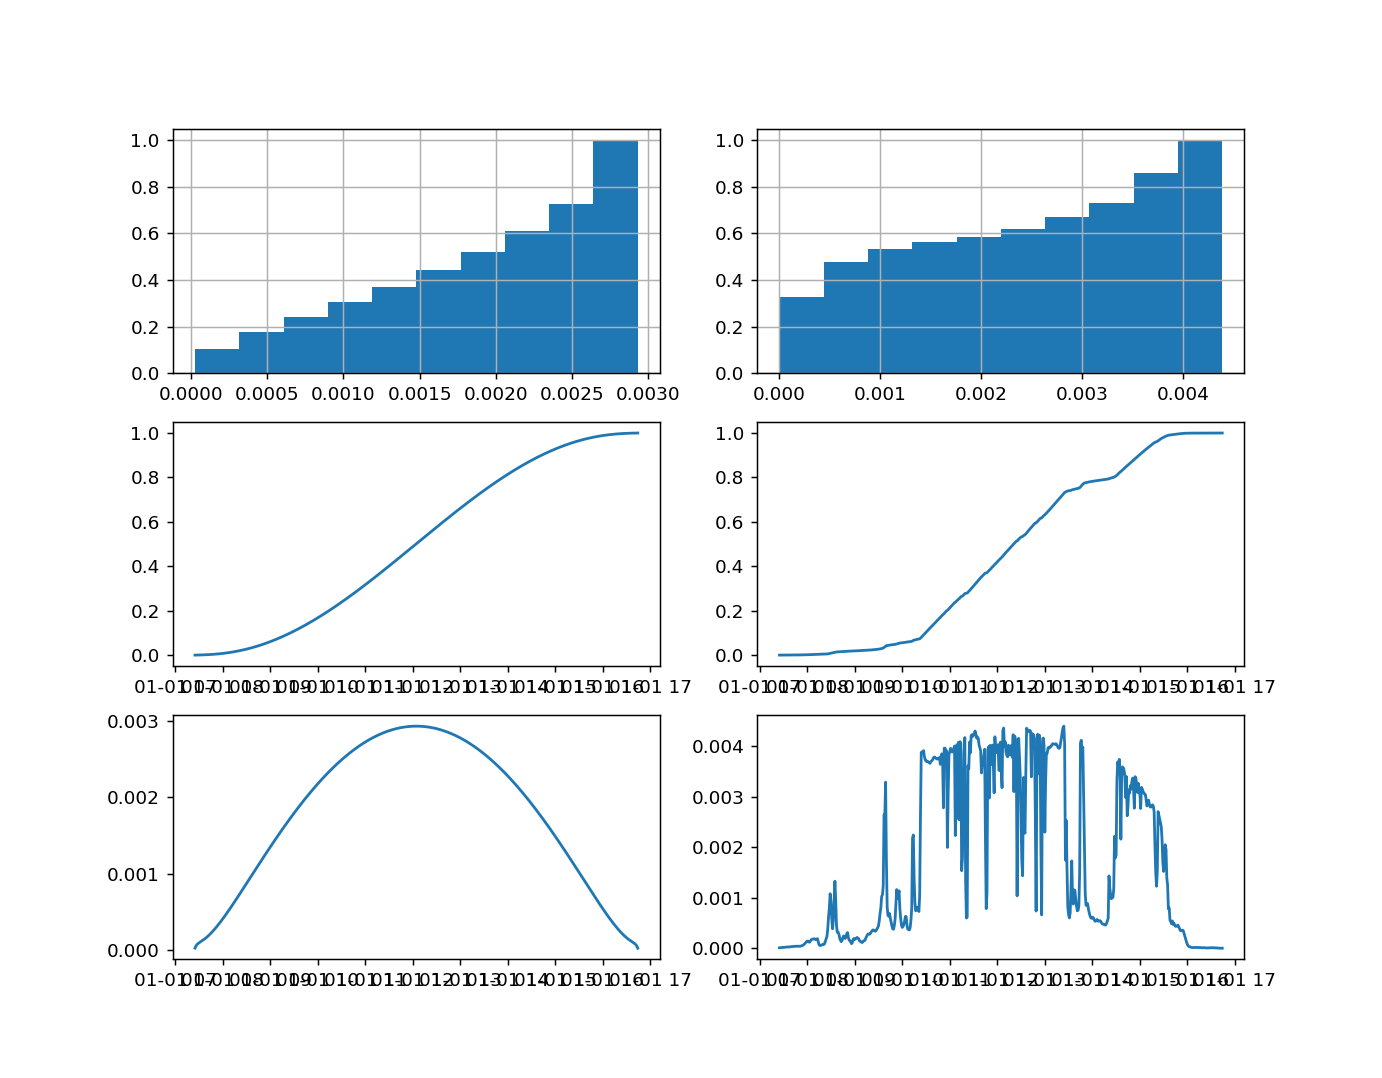

In [55]:
fig, ax = plt.subplots(nrows=3, ncols=2)
from scipy.integrate import trapz
tmp = clear_skies['ghi'] / trapz(clear_skies['ghi'])
tmp = tmp[tmp > 0]
tmp.hist(cumulative=True, normed=1, ax=ax[0, 0])
ax[1, 0].plot(tmp.index, np.cumsum(tmp))
ax[2, 0].plot(tmp.index, tmp)

# print(sample['Global 40-South LI-200 [W/m^2]'])
tmp2 = sample['Global 40-South LI-200 [W/m^2]'].dropna() / trapz(sample['Global 40-South LI-200 [W/m^2]'].dropna())
tmp2 = tmp2[tmp2 > 0]
# print(tmp2)
tmp2.hist(cumulative=True, normed=1, ax=ax[0, 1])
ax[1, 1].plot(tmp2.index, np.cumsum(tmp2))
ax[2, 1].plot(tmp2.index, tmp2)


In [107]:
import numpy as np
import pandas as pd
from collections import OrderedDict


def detect_clearsky_bhe(measured, clearsky, times, window_length,
                    mean_diff=75, max_diff=75,
                    lower_line_length=-5, upper_line_length=10,
                    var_diff=0.005, slope_dev=8, max_iterations=20,
                    return_components=False):
    """
    Detects clear sky times according to the algorithm developed by Reno
    and Hansen for GHI measurements [1]. The algorithm was designed and
    validated for analyzing GHI time series only. Users may attempt to
    apply it to other types of time series data using different filter
    settings, but should be skeptical of the results.

    The algorithm detects clear sky times by comparing statistics for a
    measured time series and an expected clearsky time series.
    Statistics are calculated using a sliding time window (e.g., 10
    minutes). An iterative algorithm identifies clear periods, uses the
    identified periods to estimate bias in the clearsky data, scales the
    clearsky data and repeats.

    Clear times are identified by meeting 5 criteria. Default values for
    these thresholds are appropriate for 10 minute windows of 1 minute
    GHI data.

    Parameters
    ----------
    measured : array or Series
        Time series of measured values.
    clearsky : array or Series
        Time series of the expected clearsky values.
    times : DatetimeIndex
        Times of measured and clearsky values.
    window_length : int
        Length of sliding time window in minutes. Must be greater than 2
        periods.
    mean_diff : float
        Threshold value for agreement between mean values of measured
        and clearsky in each interval, see Eq. 6 in [1].
    max_diff : float
        Threshold value for agreement between maxima of measured and
        clearsky values in each interval, see Eq. 7 in [1].
    lower_line_length : float
        Lower limit of line length criterion from Eq. 8 in [1].
        Criterion satisfied when
        lower_line_length < line length difference < upper_line_length
    upper_line_length : float
        Upper limit of line length criterion from Eq. 8 in [1].
    var_diff : float
        Threshold value in Hz for the agreement between normalized
        standard deviations of rate of change in irradiance, see Eqs. 9
        through 11 in [1].
    slope_dev : float
        Threshold value for agreement between the largest magnitude of
        change in successive values, see Eqs. 12 through 14 in [1].
    max_iterations : int
        Maximum number of times to apply a different scaling factor to
        the clearsky and redetermine clear_samples. Must be 1 or larger.
    return_components : bool
        Controls if additional output should be returned. See below.

    Returns
    -------
    clear_samples : array or Series
        Boolean array or Series of whether or not the given time is
        clear. Return type is the same as the input type.

    components : OrderedDict, optional
        Dict of arrays of whether or not the given time window is clear
        for each condition. Only provided if return_components is True.

    alpha : scalar, optional
        Scaling factor applied to the clearsky_ghi to obtain the
        detected clear_samples. Only provided if return_components is
        True.

    References
    ----------
    [1] Reno, M.J. and C.W. Hansen, "Identification of periods of clear
    sky irradiance in time series of GHI measurements" Renewable Energy,
    v90, p. 520-531, 2016.

    Notes
    -----
    Initial implementation in MATLAB by Matthew Reno. Modifications for
    computational efficiency by Joshua Patrick and Curtis Martin. Ported
    to Python by Will Holmgren, Tony Lorenzo, and Cliff Hansen.

    Differences from MATLAB version:

        * no support for unequal times
        * automatically determines sample_interval
        * requires a reference clear sky series instead calculating one
          from a user supplied location and UTCoffset
        * parameters are controllable via keyword arguments
        * option to return individual test components and clearsky scaling
          parameter

    Ben Ellis:
        Updating code to output results of metrics test (c1...c6).
    """

    # calculate deltas in units of minutes (matches input window_length units)
    deltas = np.diff(times) / np.timedelta64(1, '60s')

    # determine the unique deltas and if we can proceed
    unique_deltas = np.unique(deltas)
    if len(unique_deltas) == 1:
        sample_interval = unique_deltas[0]
    else:
        raise NotImplementedError('algorithm does not yet support unequal ' \
                                  'times. consider resampling your data.')

    samples_per_window = int(window_length / sample_interval)

    # generate matrix of integers for creating windows with indexing
    from scipy.linalg import hankel
    H = hankel(np.arange(samples_per_window),
               np.arange(samples_per_window-1, len(times)))

    # calculate measurement statistics
    meas_mean = np.mean(measured[H], axis=0)
    meas_max = np.max(measured[H], axis=0)
    meas_slope = np.diff(measured[H], n=1, axis=0)
    # matlab std function normalizes by N-1, so set ddof=1 here
    meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
    meas_slope_max = np.max(np.abs(meas_slope), axis=0)
    meas_line_length = np.sum(np.sqrt(
        meas_slope*meas_slope + sample_interval*sample_interval), axis=0)
    
    print(meas_mean.shape)
    print(meas_max.shape)
    print(meas_slope.shape)
    print(meas_slope_nstd.shape)
    print(meas_slope_max.shape)
    print(meas_line_length.shape)
    meas_df = pd.DataFrame()
    meas_df['mean'] = meas_mean
    meas_df['max'] = meas_max
    # meas_df['slope'] = np.mean(meas_slope, axis=1)
    meas_df['slope_max'] = meas_slope_max
    meas_df['slope_nstd'] = meas_slope_nstd
    meas_df['line_length'] = meas_line_length

    # calculate clear sky statistics
    clear_mean = np.mean(clearsky[H], axis=0)
    clear_max = np.max(clearsky[H], axis=0)
    clear_slope = np.diff(clearsky[H], n=1, axis=0)
    clear_slope_max = np.max(np.abs(clear_slope), axis=0)

    from scipy.optimize import minimize_scalar

    alpha = 1
    for iteration in range(max_iterations):
        clear_line_length = np.sum(np.sqrt(
            alpha*alpha*clear_slope*clear_slope +
            sample_interval*sample_interval), axis=0)

        line_diff = meas_line_length - clear_line_length

        # evaluate comparison criteria
        c1 = np.abs(meas_mean - alpha*clear_mean) < mean_diff
        c2 = np.abs(meas_max - alpha*clear_max) < max_diff
        c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
        c4 = meas_slope_nstd < var_diff
        c5 = (meas_slope_max - alpha*clear_slope_max) < slope_dev
        c6 = (clear_mean != 0) & ~np.isnan(clear_mean)
        clear_windows = c1 & c2 & c3 & c4 & c5 & c6
        
        # create array to return                                                  
        clear_samples = np.full_like(measured, False, dtype='bool')
        # find the samples contained in any window classified as clear
        clear_samples[np.unique(H[:, clear_windows])] = True

        # find a new alpha
        previous_alpha = alpha
        clear_meas = measured[clear_samples]
        clear_clear = clearsky[clear_samples]
        def rmse(alpha):
            return np.sqrt(np.mean((clear_meas - alpha*clear_clear)**2))
        alpha = minimize_scalar(rmse).x
        if round(alpha*10000) == round(previous_alpha*10000):
            break
    else:
        import warnings
        warnings.warn('failed to converge after %s iterations' \
                      % max_iterations, RuntimeWarning)

    clear_mean = clear_mean * alpha
    clear_max = clear_max * alpha
    clear_slope = clear_slope * alpha
    clear_slope_max = clear_slope_max * alpha
    
    cs_df = pd.DataFrame()
    cs_df['mean_cs'] = clear_mean
    cs_df['max_cs'] = clear_max
    # cs_df['slope'] = clear_slope
    cs_df['slope_max_cs'] = clear_slope_max
    # cs_df['slope_nstd'] = clear_slop_nstd
    cs_df['line_length_cs'] = clear_line_length

    # be polite about returning the same type as was input
    if isinstance(measured, pd.Series):
        clear_samples = pd.Series(clear_samples, index=times)

    if return_components:
        components = OrderedDict()
        components['mean_diff'] = c1
        components['max_diff'] = c2
        components['line_length'] = c3
        components['slope_nstd'] = c4
        components['slope_max'] = c5
        components['mean_nan'] = c6
        components['windows'] = clear_windows
        return clear_samples, components, alpha, meas_df, cs_df
    else:
        return clear_samples


In [119]:
start_date = '2014-07-01'
end_date = '2014-07-08'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()

In [120]:
clear_skies = system_loc.get_clearsky(sample.index)

In [121]:
is_clear, components, alpha, meas_df, cs_df = detect_clearsky_bhe(sample['Global 40-South LI-200 [W/m^2]'], 
                                                                     clear_skies['ghi'], sample.index, 10, 
                                                                     return_components=True)


(10071,)
(10071,)
(9, 10071)
(10071,)
(10071,)
(10071,)


/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:128: RuntimeWarning: invalid value encountered in true_divide
/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:167: RuntimeWarning: invalid value encountered in less


In [122]:
meas_df = meas_df.join(cs_df)

In [123]:
meas_df['windows'] = components['windows']

In [124]:
while len(meas_df) < len(sample):
    meas_df.loc[len(meas_df)] = [np.nan] * 9 + [False]
meas_df.index = sample.index

In [126]:
meas_df = meas_df[(meas_df.index >= '2014-07-01 11:30:00') & (meas_df.index < '2014-07-01 13:30:00')]

In [130]:
pd.options.display.max_rows = 1000

In [131]:
meas_df

,mean,max,slope_max,slope_nstd,line_length,mean_cs,max_cs,slope_max_cs,line_length_cs,windows
2014-07-01 11:30:00-07:00,1036.2790,1072.990,12.440,0.003794,62.873829,953.973066,955.933624,0.515844,9.895663,False
2014-07-01 11:31:00-07:00,1030.0540,1060.550,11.930,0.003729,51.482232,954.421270,956.314080,0.500838,9.840382,False
2014-07-01 11:32:00-07:00,1025.1260,1048.620,9.790,0.003391,40.642162,954.854427,956.679451,0.485823,9.786631,False
2014-07-01 11:33:00-07:00,1021.3710,1042.670,9.790,0.003553,35.628518,955.272528,957.029728,0.470797,9.734437,False
2014-07-01 11:34:00-07:00,1018.3740,1036.380,9.790,0.003757,31.171825,955.675564,957.364906,0.455762,9.683832,False
2014-07-01 11:35:00-07:00,1016.6750,1029.280,9.790,0.004438,30.766074,956.063527,957.684978,0.440718,9.634843,False
2014-07-01 11:36:00-07:00,1016.0330,1026.820,9.790,0.004643,31.721807,956.436410,957.989936,0.425665,9.587500,False
2014-07-01 11:37:00-07:00,1015.3470,1022.860,9.790,0.004472,29.915685,956.794206,958.279776,0.410603,9.541831,False
2014-07-01 11:38:00-07:00,1014.7630,1022.860,6.690,0.003153,23.955789,957.136906,958.554490,0.395534,9.497863,False
2014-07-01 11:39:00-07:00,1015.0750,1022.860,6.690,0.003138,23.776143,957.464504,958.814075,0.380456,9.455624,False


# Outlook

It's obvious that the default tolerances for mean_diff and max_diff are unsuitable for this data set.  While many clear sky periods are detected, it is alarming that the method fails for seemingly obvious cases as well.  The RTC irradiance measures do not suffer from this inconsistency using default parameters (at least not as noticeably).